# Hopefully final notebook for semantic segmentation component

In [1]:
# entire code is being run on an Ubuntu kernel. 
# not many QoL libraries are needed.
# your mileage may vary.
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# dataset imports
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch.utils.data.dataloader import default_collate
from PIL import Image
# from torchvision.transforms import ToTensor, Resize, ToPILImage, Lambda
import torchvision.transforms as transforms

# AI imports
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ReLU, BatchNorm2d
from torch.nn import ConvTranspose2d, Sequential, Upsample, Softmax, CrossEntropyLoss
from torch.nn import functional as F
from torchvision.utils import make_grid
import torch

# statistics
from torchinfo import summary
import torchmetrics as TM

# test if GPU acceleration is working
torch.cuda.is_available()

True

## Standard Helper Functions

In [2]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join('./models/', cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        try:
            return x.cuda()
        except AttributeError:
            return x
    else:
        return x.cpu()
    
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

t2img = transforms.ToPILImage()

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


## Dataset Loading and Initialization

In [3]:
# load in the ade20k pickle file to examine it.
root = './ade20k/ADEChallengeData2016/'
images_dir = f"{root}/images"
annotations_dir = f"{root}/annotations"
# with open(root + 'index_ade20k.pkl', 'rb') as f:
#     index_ade20k = pickle.load(f)

In [4]:
images_training_dir = f"{images_dir}/training"
annotations_training_dir =  f"{annotations_dir}/training"

images_validation_dir = f"{images_dir}/validation"
annotations_validation_dir = f"{annotations_dir}/validation"

training_images = sorted(os.listdir(images_training_dir))
print(len(training_images))

training_annotations = sorted(os.listdir(annotations_training_dir))
print(len(training_annotations))

20210
20210


In [5]:
class ADE20KDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(annotations_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        
        img_name = os.path.join(self.images_dir, image_filename)
        image = Image.open(img_name).convert("RGB")
        
        # Generate the mask filename based on the image filename
        mask_filename = image_filename.replace(".jpg", ".png")
        mask_name = os.path.join(self.annotations_dir, mask_filename)

        mask = Image.open(mask_name)

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)

        return image, mask

### DETOUR 1: Find a good size to scale all images to for all models moving forward

In [37]:
img_h, img_w = np.zeros((len(training_images))), np.zeros((len(training_images)))
for idx in range(len(training_images)):
    timg = read_image(images_training_dir + '/' + training_images[idx])
    img_h[idx] = timg.shape[1]
    img_w[idx] = timg.shape[2]

In [39]:
image_size = pd.DataFrame({'H': img_h, 'W': img_w}, dtype='int')
image_size.describe()

,H,W
count,20210.000000,20210.000000
mean,416.506977,515.995596
std,140.095244,194.645060
min,96.000000,130.000000
25%,256.000000,300.000000
50%,480.000000,512.000000
75%,512.000000,683.000000
max,2100.000000,2100.000000


In [43]:
image_size['ratio'] = image_size['H'] / image_size['W']

In [44]:
image_size.mode()

,H,W,ratio
0,512,683,0.749634


array([[<Axes: title={'center': 'H'}>, <Axes: title={'center': 'W'}>],
       [<Axes: title={'center': 'ratio'}>, <Axes: >]], dtype=object)

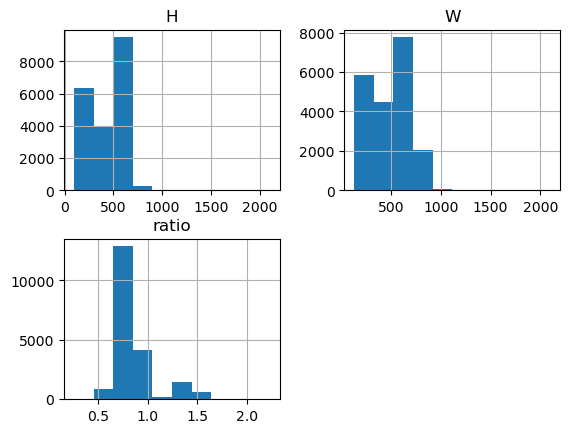

In [46]:
image_size.hist()

In [48]:
image_size[image_size['H'] > 768].shape[0] + image_size[image_size['W'] > 768].shape[0]

900

#### /DETOUR 1

### Define custom parameters and create data loaders

In [6]:
train_batch = 8
test_batch = 2
target_size = 386

transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((target_size)),
    # add padding thing here based on the largest image ig
    transforms.ToTensor()
])

def irregular_image_collate(batch):
    inputs, targets = zip(*batch)

    # Calculate the maximum height and width in the batch
    max_height_input = max(img.size(1) for img in inputs)
    max_width_input = max(img.size(2) for img in inputs)

    max_height_target = max(img.size(1) for img in targets)
    max_width_target = max(img.size(2) for img in targets)

    # Calculate the maximum height and width across inputs and targets
    max_height = max(max_height_input, max_height_target)
    max_width = max(max_width_input, max_width_target)

    # Pad each input and target image to the maximum size
    padded_inputs = [F.pad(img, (0, max_width - img.size(2), 0, max_height - img.size(1))) for img in inputs]
    padded_targets = [F.pad(img, (0, max_width - img.size(2), 0, max_height - img.size(1))) for img in targets]

    # Stack the padded inputs and targets to create the batch
    padded_inputs = torch.stack(padded_inputs, dim=0)
    padded_targets = torch.stack(padded_targets, dim=0)

    return padded_inputs, padded_targets


In [7]:
train_dataset = ADE20KDataset(images_training_dir, annotations_training_dir, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=irregular_image_collate)

val_dataset = ADE20KDataset(images_validation_dir, annotations_validation_dir, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=irregular_image_collate)

## Test Dataloader

In [8]:
def visualize_image_mask(image, mask):
    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image.permute(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,2,2)
    # Turn off tick labels
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask.permute(1, 2, 0))  # for visualization we have to remove 3rd dimension of mask
    plt.show()

In [9]:
image = train_dataset[0][0]
mask = train_dataset[0][1]
print(image.shape)
print(mask.shape)

torch.Size([3, 386, 514])
torch.Size([1, 386, 514])


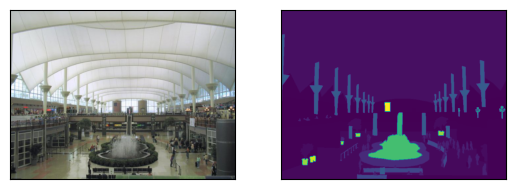

In [10]:
visualize_image_mask(image, mask)

## Everything is in order, time to build the model and train it!

## Model Definition

In [11]:
class double_conv(Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = Sequential(
            Conv2d(in_ch, out_ch, 3, padding=1),
            BatchNorm2d(out_ch),
            ReLU(inplace=True),
            Conv2d(out_ch, out_ch, 3, padding=1),
            BatchNorm2d(out_ch),
            ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = Sequential(MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [12]:
# initialise hyperparameters

In [13]:
model = UNet(n_channels=3, n_classes=150).float()
if torch.cuda.is_available():
    model.cuda()

In [14]:
summary(model, input_size=(1, 3, target_size, target_size))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 150, 386, 386]        --
├─inconv: 1-1                                 [1, 64, 386, 386]         --
│    └─double_conv: 2-1                       [1, 64, 386, 386]         --
│    │    └─Sequential: 3-1                   [1, 64, 386, 386]         38,976
├─down: 1-2                                   [1, 128, 193, 193]        --
│    └─Sequential: 2-2                        [1, 128, 193, 193]        --
│    │    └─MaxPool2d: 3-2                    [1, 64, 193, 193]         --
│    │    └─double_conv: 3-3                  [1, 128, 193, 193]        221,952
├─down: 1-3                                   [1, 256, 96, 96]          --
│    └─Sequential: 2-3                        [1, 256, 96, 96]          --
│    │    └─MaxPool2d: 3-4                    [1, 128, 96, 96]          --
│    │    └─double_conv: 3-5                  [1, 256, 96, 96]          886,272
├─down

### IoU Loss Functions

In [15]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = Softmax(dim=1)(pred)
    
    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(150) ], dim=1)

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
    
    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())

def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 150, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z

test_custom_iou_loss()

tensor(5.7822, grad_fn=<NegBackward0>)

## Model Training

In [16]:
# Train the model for a single epoch
def train_model(model, loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)

    running_loss = 0.0
    running_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)
        
        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
        running_samples += targets.size(0)
        running_loss += loss.item()

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))

### Helper Functions

In [17]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()
    
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)
    
    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(150, average='micro'))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(150, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f"Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]"
    print(title)

    # Close all previously open figures.
    close_figures()
    
    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")
    
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    
    if show_plot is False:
        close_figures()
    else:
        plt.show()

In [18]:
def test_dataset_accuracy(model, loader):
    model.eval()
    iou = TM.classification.MulticlassJaccardIndex(3, average='micro')
    pixel_metric = TM.classification.MulticlassAccuracy(3, average='micro')
    
    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []
    
    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = inputs
        targets = targets
        predictions = model(inputs)
        
        pred_probabilities = Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())
        
        del inputs
        del targets
        del predictions
    # end for
    
    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)
    
    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")


In [19]:
torch.cuda.empty_cache()
save_path = os.path.join('./logs/', "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
train_x, train_y = next(iter(train_loader))
print_test_dataset_masks(model, train_x, train_y, epoch=0, save_path=None, show_plot=True)